In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data, DataLoader
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, 128, heads=6, dropout=0.1)
        self.conv2 = GATConv(128 * 6, 64, heads=6, concat=False, dropout=0.1)
        self.conv3 = GATConv(64, out_channels, heads=6, concat=False, dropout=0.1)
        self.norm1 = torch.nn.LayerNorm(128 * 6)
        self.norm2 = torch.nn.LayerNorm(64)
        self.dropout = torch.nn.Dropout(p=0.1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.dropout(x)
        x = F.selu(self.conv1(x, edge_index))
        x = self.norm1(x)
        x = self.dropout(x)
        x = F.selu(self.conv2(x, edge_index))
        x = self.norm2(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return x

class GATDecoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATDecoder, self).__init__()
        self.conv1 = GATConv(in_channels, 64, heads=6, dropout=0.1)
        self.conv2 = GATConv(64 * 6, 128, heads=6, concat=False, dropout=0.1)
        self.conv3 = GATConv(128, out_channels, heads=6, concat=False, dropout=0.1)
        self.norm1 = torch.nn.LayerNorm(64 * 6)
        self.norm2 = torch.nn.LayerNorm(out_channels)
        self.dropout = torch.nn.Dropout(p=0.1)

    def forward(self, x, edge_index):
        x = self.dropout(x)
        x = F.selu(self.conv1(x, edge_index))
        x = self.norm1(x)
        x = self.dropout(x)
        x = F.selu(self.conv2(x, edge_index))
        x = self.norm2(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return x

class GATAutoencoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GATAutoencoder, self).__init__()
        self.encoder = GATEncoder(in_channels, hidden_channels)
        self.decoder = GATDecoder(hidden_channels, in_channels)

    def forward(self, data):
        z = self.encoder(data)
        x_hat = self.decoder(z, data.edge_index)
        return x_hat, z

In [4]:
with open("/kaggle/input/graph-torch-geometric/graphs.picke", "rb") as f:
    gs = pickle.load(f)
gs[0]

Data(x=[3, 1, 128], edge_index=[2, 3])

In [5]:
# Normalize embeddings to the range [0, 1]
def normalize_embeddings(data):
    min_val = data.min(dim=0, keepdim=True)[0]
    max_val = data.max(dim=0, keepdim=True)[0]
    data = (data - min_val) / (1 + max_val - min_val)
    return data

In [6]:
def convert_graph_datatype(g):
    x = torch.reshape(g.x, (g.x.shape[0], 128))
#     x = normalize_embeddings(x)
    return Data(x=x.type(torch.float), edge_index=g.edge_index).to("cuda")

converted_graph = [convert_graph_datatype(g) for g in gs]

In [7]:
# Define DataLoader
batch_size = 1
num_features = 128
loader = DataLoader(converted_graph, batch_size=batch_size, shuffle=True)

/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [8]:
# Model instantiation
model = GATAutoencoder(num_features, hidden_channels=8).to("cuda")
# model = GATAutoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.MSELoss()

In [9]:
# Training loop
def train():
    model.train()
    losses = []
    for data in loader:
        optimizer.zero_grad()
        x_hat, z = model(data)
        loss = criterion(x_hat, data.x)  # Reconstruction loss
        losses.append(loss.to("cpu").detach().numpy())
        loss.backward()
        optimizer.step()
    return np.mean(losses)

In [10]:
# Training loop
def train():
    model.train()
    losses = []
    for data in loader:
        optimizer.zero_grad()
        x_hat, z = model(data)
        loss = criterion(x_hat, data.x)  # Reconstruction loss
        losses.append(loss.to("cpu").detach().numpy())
        loss.backward()
        optimizer.step()
    return np.mean(losses)

In [11]:
# Run training
losses = []
for epoch in range(1000):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Training Loss: {loss.item():.4f}')

Epoch 1, Training Loss: 182083776.0000
Epoch 101, Training Loss: 106496240.0000
Epoch 201, Training Loss: 102644736.0000
Epoch 301, Training Loss: 91251336.0000
Epoch 401, Training Loss: 90616216.0000
Epoch 501, Training Loss: 88846672.0000
Epoch 601, Training Loss: 87948424.0000
Epoch 701, Training Loss: 85955640.0000
Epoch 801, Training Loss: 85669480.0000
Epoch 901, Training Loss: 84979944.0000


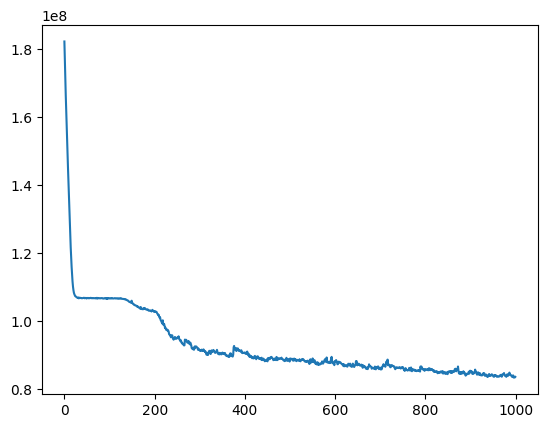

In [12]:
plt.plot(losses)

In [13]:
threshold = np.mean(losses) + 3*np.std(losses)
threshold

124489893.0

In [14]:
# Inference for anomaly detection
def detect_anomalies(data, threshold=0.1):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(loader):
#             print(i)
            x_hat, z = model(data)
            reconstruction_error = torch.mean((x_hat - data.x) ** 2, dim=1)
            anomalies = reconstruction_error > threshold
    return anomalies, reconstruction_error, data.x, x_hat

In [15]:
# Detect anomalies in the dataset
anomalies, reconstruction_error, x, x_hat = detect_anomalies(data = loader, threshold = threshold)
print(f"Anomalies detected: {anomalies.sum().item()}")

Anomalies detected: 4


In [16]:
reconstruction_error

tensor([2.2804e+06, 5.8531e+07, 8.5198e+07, 3.6850e+07, 1.3321e+08, 8.7134e+07,
        1.5392e+08, 8.6154e+07, 1.1762e+08, 8.9720e+07, 1.3264e+08, 8.7120e+07,
        9.6263e+07, 2.1739e+08, 1.2088e+08, 5.7797e+07, 7.5629e+07, 5.8834e+07,
        7.8142e+07, 7.3675e+07], device='cuda:0')

In [17]:
x

tensor([[5.2300e+02, 2.8766e+04, 6.5740e+03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.2300e+02, 2.8766e+04, 4.8900e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.2300e+02, 2.8766e+04, 1.8380e+03,  ..., 2.8723e+04, 2.0000e+00,
         0.0000e+00],
        ...,
        [5.2300e+02, 2.8766e+04, 4.8900e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.2300e+02, 2.8766e+04, 1.8380e+03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.2300e+02, 2.8766e+04, 4.8900e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], device='cuda:0')

In [18]:
x_hat

tensor([[ 5.0835e+02,  2.6682e+04,  5.8419e+03,  ...,  1.1989e+01,
         -6.5848e+01, -6.3927e+01],
        [ 4.8666e+02,  2.7412e+04,  7.6864e+02,  ...,  7.9621e+02,
          1.0613e+03,  8.9802e+02],
        [ 5.2818e+02,  2.9930e+04,  1.4363e+03,  ...,  2.0061e+04,
          1.4700e+04,  1.0990e+04],
        ...,
        [ 5.1767e+02,  2.8086e+04,  1.0232e+03,  ..., -7.5893e+01,
         -8.7802e+01, -7.9976e+01],
        [ 5.1518e+02,  2.8175e+04,  1.3782e+03,  ..., -1.7435e+02,
         -2.4469e+02, -1.8040e+02],
        [ 4.8746e+02,  2.6709e+04,  2.0933e+03,  ...,  4.9366e+02,
          3.2291e+02,  3.9471e+02]], device='cuda:0')

In [19]:
torch.save(model, "ae_gat_model_selu.pth")

In [20]:
ccc = torch.load("ae_gat_model_selu.pth")
ccc.eval()

GATAutoencoder(
  (encoder): GATEncoder(
    (conv1): GATConv(128, 128, heads=6)
    (conv2): GATConv(768, 64, heads=6)
    (conv3): GATConv(64, 8, heads=6)
    (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): GATDecoder(
    (conv1): GATConv(8, 64, heads=6)
    (conv2): GATConv(384, 128, heads=6)
    (conv3): GATConv(128, 128, heads=6)
    (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)